## Problem Statement

Wallkart is a supermarket chain across South America and has multiple stores present in different regions. For each of their stores , they want to optimise the placement of the items  to increase the visibility and therefore the overall sales. 
 
You are provided with the sales dataset from one of the Wallkart store. The dataset contains transactions including customer id and date of purchase. Use market basket analysis to find out the most frequent items bought together and which items should be placed together to increase sales. Also provide insights around the transaction data such as most frequently bought item , day wise preference of customers.

1. Customer ID : Unique Customer ID
2. Date : Date of purchase
3. Item : Item bought by customer




## Table of Content

1. **[Import Libraries](#lib)**
2. **[Load the Data](#data)**
3. **[Data Exploration](#eda)**
4. **[Data Preperation](#prep)**
5. **[Frerquenct Itemsets and Rules ](#rules)**
  

<a id="lib"></a>
### Step 1 : Load required libraries 

In [33]:
#import the required libraries 
import pandas as pd 
import numpy as np 
import os
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt


<a id="data"></a>
### Step 2 : Load the input data 

In [68]:
#load the transactions dataset and view the top rows
df = pd.read_csv('dataset.csv')
df.head()

,Customer ID,Date,Item
0,1808,21/07/15,tropical fruit
1,2552,05/01/15,whole milk
2,2300,19/09/15,pip fruit
3,1187,12/12/15,other vegetables
4,3037,01/02/15,whole milk


In [69]:
#validate the shape of the data 
df.shape

(38765, 3)

In [70]:
#check for datatypes of colums 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Customer ID  38765 non-null  int64 
 1   Date         38765 non-null  object
 2   Item         38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [71]:
#convert the date column to datetime datatype  
df['Date']=df['Date'].apply(pd.to_datetime)

In [72]:
#add day of the week column to analyse item sales data 
df['Day of Week'] = df['Date'].apply(lambda time: time.dayofweek)

In [73]:
#add the weekday lable 
def weekday(day):
    if day == 0:
        return 'Mon'
    elif day == 1:
        return 'Tue'
    elif day == 2:
        return 'Wed'
    elif day == 3:
        return 'Thur'
    elif day == 4:
        return 'Fri'
    elif day == 5:
        return 'Sat'
    else:
        return 'Sun'

df['Weekday'] = df['Day of Week'].apply(weekday)

In [75]:
#view the dataframe
df

,Customer ID,Date,Item,Day of Week,Weekday
0,1808,2015-07-21,tropical fruit,1,Tue
1,2552,2015-05-01,whole milk,4,Fri
2,2300,2015-09-19,pip fruit,5,Sat
3,1187,2015-12-12,other vegetables,5,Sat
4,3037,2015-01-02,whole milk,4,Fri
...,...,...,...,...,...
38760,4471,2014-08-10,sliced cheese,6,Sun
38761,2022,2014-02-23,candy,6,Sun
38762,1097,2014-04-16,cake bar,2,Wed
38763,1510,2014-03-12,fruit/vegetable juice,2,Wed


<a id="eda"></a>
### Step 3 : Explore the data 

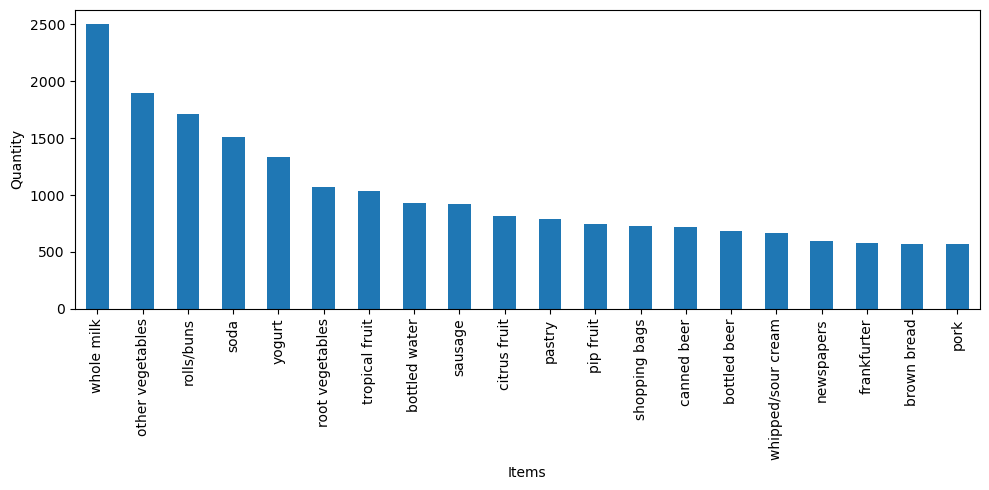

In [76]:
#view the top selling items 
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
df['Item'].value_counts()[:20].plot(ax=ax, kind='bar', xlabel='Items', ylabel='Quantity')
plt.show()

As we can observe , whole milk , vegetables , roll are the top most sold items in the Wallkart store.

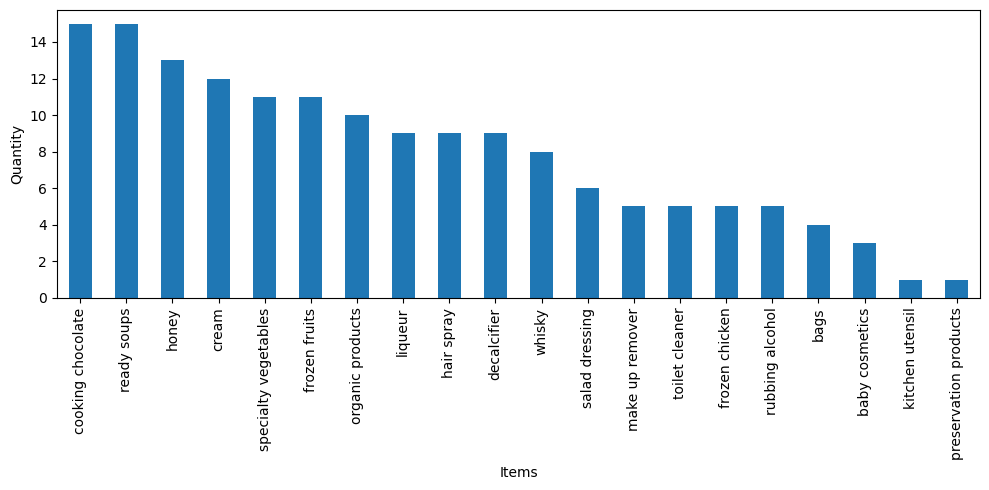

In [77]:
# view the least selling items 
fig, ax = plt.subplots()
df['Item'].value_counts()[-20:].plot(ax=ax, kind='bar', xlabel='Items', ylabel='Quantity')

plt.show()

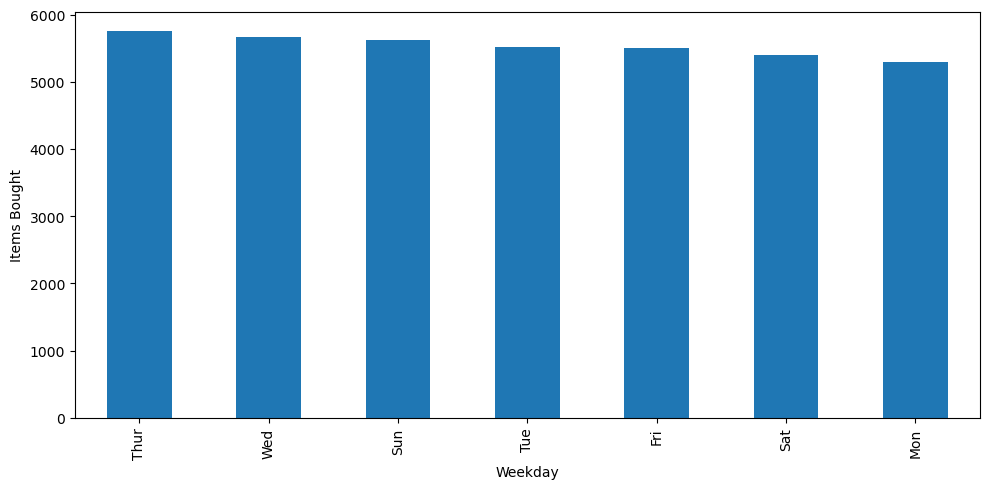

In [78]:
# Weekday wise sales 
fig, ax = plt.subplots()
df['Weekday'].value_counts()[:20].plot(ax=ax, kind='bar', xlabel='Weekday', ylabel='Items Bought')

plt.show()

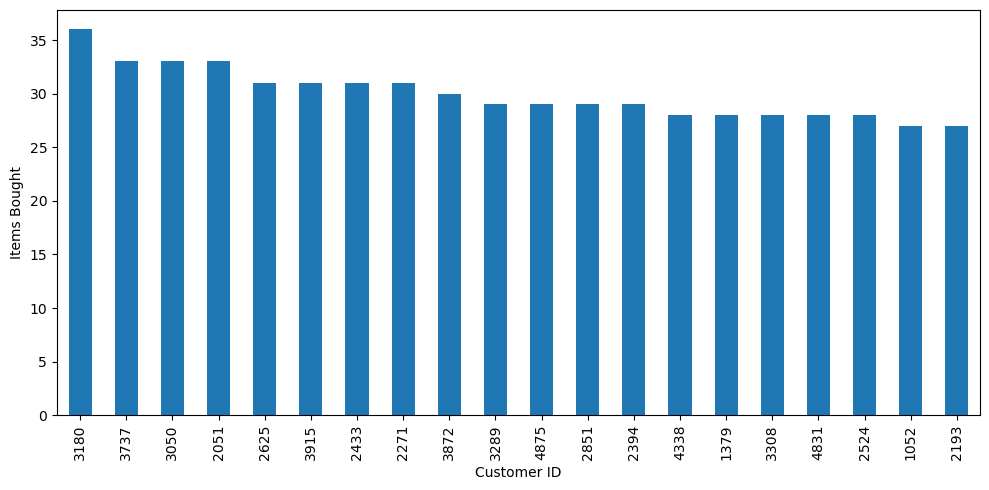

In [79]:
# Top Loyal customers 
fig, ax = plt.subplots()
df['Customer ID'].value_counts()[:20].plot(ax=ax, kind='bar', xlabel='Customer ID', ylabel='Items Bought')

plt.show()

In [80]:
def freq_plot(item):
    fig, ax = plt.subplots()
    df[df['Item']== item]['Weekday'].value_counts().plot(ax=ax, kind='bar', xlabel='Weekday', ylabel='Items Bought')
    return plt.show()


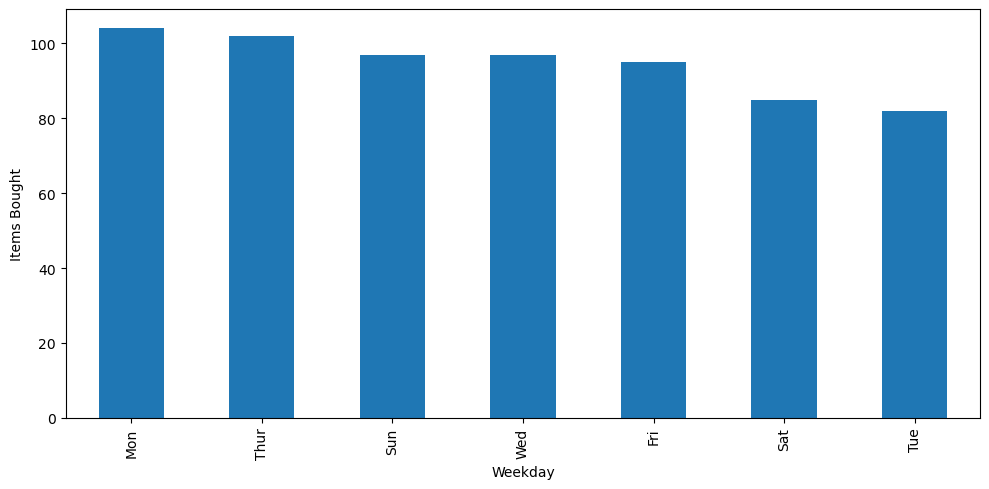

In [97]:
#Item sales distribution over weekdays 
freq_plot('whipped/sour cream')

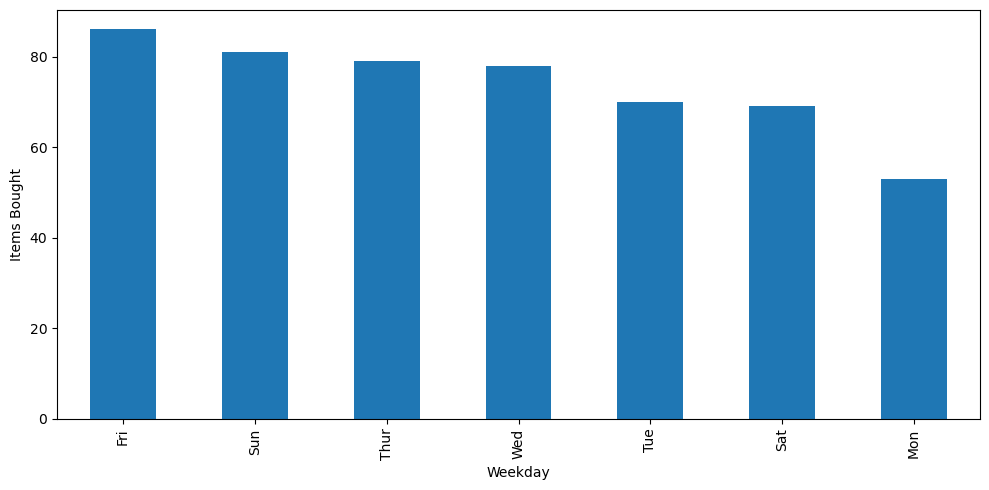

In [98]:
freq_plot('beef')

<a id="prep"></a>
## Data Preperation 

In [99]:
#create the unique invoice id combining customer id and date
df['invoice_id'] = df['Customer ID'].astype(str)+'_'+df['Date'].astype(str)

df.head()

,Customer ID,Date,Item,Day of Week,Weekday,invoice_id
0,1808,2015-07-21,tropical fruit,1,Tue,1808_2015-07-21
1,2552,2015-05-01,whole milk,4,Fri,2552_2015-05-01
2,2300,2015-09-19,pip fruit,5,Sat,2300_2015-09-19
3,1187,2015-12-12,other vegetables,5,Sat,1187_2015-12-12
4,3037,2015-01-02,whole milk,4,Fri,3037_2015-01-02


In [25]:
#convert the transaction data into crosstab form for market basket analysis 
useritem_df = pd.crosstab(df['invoice_id'], df['Item'])
useritem_df.head()

Item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
invoice_id,,,,,,,,,,,,,,,,,,,,,
1000_2014-06-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1000_2015-03-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1000_2015-05-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000_2015-07-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000_2015-11-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Along the rows, we have all the  customer's unique invoice id and the columns contains all the unique items and respective quantities 

In [23]:
#shape of the useritem dataset
useritem_df.shape

(14963, 167)

We have total of 167 unique items that has been bought by the customers in the given period from the store. In market basket analysis , the quanity of the items bought doesnt matter and hence we make the values as 1 where quanity is more than 1 using a helper function. 

In [26]:
#create and apply a function on user item dataset that returns ~max(0,1)
def min_max_fix(quantity):
    val = 0
    if quantity > 0:
        val = 1
    return val

basket_input = useritem_df.applymap(min_max_fix)

<a id="rules"></a>
## Frerquenct Itemsets and Rules 

In [27]:
#Use apriori for running market basket analysis to generate rules and frequent item set
frequent_itemsets = apriori(basket_input, min_support=0.001, use_colnames=True)

/Users/49689/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### Support
It indicates the overall popularity of a given item using the below formula:

    Support(item) = Transactions comprising the item / Total transactions


A high support value means that the item is present in most customer purchases

### Confidence
It indicates the likelihood of different purchase combinations using the below formula :

    Confidence (Beer -> Diapers) = Transactions comprising Beer and Diapers / Transactions comprising Beer



### Lift
Ratio of confidence and Support ( Indicates how likely the customers to buy other product if they buy produ t in consideration) 

    Lift = Confidence (Beer -> Diapers) / Support(Beer)



In [28]:
# use the association rules 
rules = association_rules(frequent_itemsets, metric="lift")


In [29]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bottled water),(UHT-milk),0.060683,0.021386,0.001069,0.017621,0.823954,-0.000228,0.996168
1,(UHT-milk),(bottled water),0.021386,0.060683,0.001069,0.050000,0.823954,-0.000228,0.988755
2,(other vegetables),(UHT-milk),0.122101,0.021386,0.002139,0.017515,0.818993,-0.000473,0.996060
3,(UHT-milk),(other vegetables),0.021386,0.122101,0.002139,0.100000,0.818993,-0.000473,0.975443
4,(sausage),(UHT-milk),0.060349,0.021386,0.001136,0.018826,0.880298,-0.000154,0.997391


In [67]:
#sort the rules 
rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(15)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
623,(rolls/buns),(whole milk),0.110005,0.157923,0.013968,0.126974,0.804028,-0.003404,0.964550
622,(whole milk),(rolls/buns),0.157923,0.110005,0.013968,0.088447,0.804028,-0.003404,0.976350
694,(yogurt),(whole milk),0.085879,0.157923,0.011161,0.129961,0.822940,-0.002401,0.967861
695,(whole milk),(yogurt),0.157923,0.085879,0.011161,0.070673,0.822940,-0.002401,0.983638
551,(soda),(other vegetables),0.097106,0.122101,0.009691,0.099794,0.817302,-0.002166,0.975219
550,(other vegetables),(soda),0.122101,0.097106,0.009691,0.079365,0.817302,-0.002166,0.980729
649,(sausage),(whole milk),0.060349,0.157923,0.008955,0.148394,0.939663,-0.000575,0.988811
648,(whole milk),(sausage),0.157923,0.060349,0.008955,0.056708,0.939663,-0.000575,0.996140
624,(yogurt),(rolls/buns),0.085879,0.110005,0.007819,0.091051,0.827697,-0.001628,0.979147
625,(rolls/buns),(yogurt),0.110005,0.085879,0.007819,0.071081,0.827697,-0.001628,0.984071


### Conclusion 

The above report shows the frequently-bought-together items.Here, the “antecedents” and “consequents” columns show items that are frequently purchased together.For example, the first row of the dataset tells us that if a person were to buy rolls/buns, then they are also likely to purchase whole milk.

The resulting table shows that the four most popular product combinations that are frequently bought together are:

1. rolls/buns and whole milk
2. yogurt and whole milk
3. soda and other vegetables
4. sausages and whole milk